# Motivation and Dataset Acquisition

## Motivation

Livestock farming is one of the major sectors of the agricultural industry. It is the source
of a significant part of our diet including our meats and dairy products. As we are dependent on
it for our day-to-day sustenance, we need to try to optimize this process as much as possible.


In countries that practice livestock farming, a lot of the tasks are being done manually;
the caretaker goes to the barn and gives the appropriate care for each animal and collects their
produce. The tasks for livestock farming are straightforward and well-defined but they are
tedious and take time. This situation naturally lends itself to automation as robots are very good
at doing repetitive but well-defined tasks. The hope is that the automation of livestock farming
will result in a reduction in human labor and an increase in production and efficiency.


For a robot to be able to replace a human caretaker in caring for animals, it first needs to
be able to identify the type of animal before it can provide the care it needs. The reason for this
is because different types of livestock warrant different types of care. Cows for example would
need regular baths while chickens generally don’t. Their food would also differ as well the way
we collect their produce. This project will focus on solving the animal identification problem. This
can be done through the use of image classification.

## Project Goals

Our task is to create a model that, when given an input image, will provide us with a label
(chosen from a finite set of labels) that identifies what type of animal our input image is. Ideally,
our finite set of labels would be all the types of livestock available. However, the types of
livestock in the world are very diverse and collecting a large number of images of each of these
types would prove difficult. As such, we will limit the scope of this project to only six common
classes of livestock namely: duck, chicken, pig, goat, cow, sheep.

We will split the project into two notebooks. This one, the first one, will focus on acquiring the data and cleaning it. A huge chunk of the material here in the data scrapping part is borrowed from provided resources in CS 5242 Neural Networks and Deep Learning. The second notebook will focus on training the model and providing meaningful insights about the results.

## Dataset Acquisition and Cleaning

Our task for this notebook is further split into four subsections:
* Getting the data
* Visualizing the data
* Cleaning the data
* Segregating the data

We will first get the data through the use of FlickAPI and then do some quick visualizations on the acquired dataset to make sure that we it generally makes sense and that we have gathered enough. Next, we will do our basic cleaning of the data by removing noise and duplicates. Note that here we won't transform the data yet as that will be covered in the second notebook. Finally we will segregate our cleaned data for convenience.

## I. Getting the Data

Here we use the FlickrAPI to get some images from the web. This is **heavily borrowed from the provided image scrapper showcase by Mr. Zhao Jingwei**. A few changes were made and highlighted so that the scrapper better fits to the needs of this specific project.

Let's first do some quick imports of the libraries we will be needing

In [18]:
import pandas as pd
import os
import requests
from tqdm import tqdm

In [ ]:
from flickrapi import FlickrAPI

key = ''
secret = ''

`fetch_image_link` get a list of image urls when given a query. Once we have the image urls we can then download these through the use of the `requests` package.

We made a few changes to fetch_image_link:
* We used `url_t` as the `extras`. This does two things. First, passing in this image size allows us to make sure that the image url always exist as specified in the FlickrAPI. Second, this makes sure that the max dimension of the image is 100x100. This will make it easier for us to download the image as well as make it more convenient for the later steps of image processing. Note here that we are going to use a 96x96 image size. We chose this size for two main reasons; it is small enough to allow our GPU to handle the training and it is large enough that the images and features in it are recognizable. 


* Second we pass in `old_images` as an argument that denotes a list of urls we may have previously downloaded. This extends the ability of this function to be able to exclude in the results it retrieves previous images we have already downloaded. This is useful in case we find ourselves needing to expand our dataset (which I did need to do multiple times) in the middle of the project. Secondly, because it is a set instead of a list, we make sure that there are no duplicates in the search results. Flickr doesn't guarantee it will provide a new image each query and it is quite common to see images that refer to the same url if we just walk through the results.

In [ ]:
def fetch_image_link(query, count, old_images=set()):
    flickr = FlickrAPI(key, secret)
    photos_generator = flickr.walk(text=query,
                        tag_mode='all',
                        extras='url_t',
                        sort='relevance')
    item_count = 0 
    urls = old_images.copy()
    while item_count < count + len(old_images):
        photo = next(photos_generator)
        url = photo.get('url_t')
        if url is None or url == "":
            continue
        urls.add(url)
        item_count = len(urls)
    return list(urls - old_images)


# Here we can load the previous csv files we have generated
# f = pd.read_csv(f"./some_folder/{query}_urls.csv")
# myset = set(df["0"])
myset = set()

queries = ["chicken", "duck", "goat","sheep", "pig", "cow"]
for query in queries:
    urls = fetch_image_link(query, 5000, myset)
    urls = pd.Series(urls)
    save_path = './livestock/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    category_path = f'{save_path}/{query}_urls.csv'
    print(f"Writing {query} urls to {category_path}")
    urls.to_csv(category_path)

`fetch_files_with_link` uses te request package to download the files referenced by the links we acquired. No change was made here and was directly borrowed from the source.

In [ ]:
def fetch_files_with_link(url_path):
    with open(url_path, newline="") as csvfile:
        urls = pd.read_csv(url_path, delimiter=',')
        urls = urls.iloc[:, 1].to_dict().values()

    SAVE_PATH = os.path.join(url_path.replace('_urls.csv', ''))
    if not os.path.isdir(SAVE_PATH):
        os.mkdir(SAVE_PATH)

    for idx, url in tqdm(enumerate(urls), total=len(urls)):
        print("Starting download {} of ".format(url[0] + 1), len(urls))
        try:
            resp = requests.get(url, stream=True)
            path_to_write = os.path.join(SAVE_PATH, url.split("/")[-1])
            outfile = open(path_to_write, 'wb')
            outfile.write(resp.content)
            outfile.close()
            print("Done downloading {} of {}".format(idx + 1, len(urls)))
        except:
            print("Failed to download url number {}".format(idx)) 
    print(f"Done with {url_path} download, images are saved in {SAVE_PATH}")

print("Start downloading images...")


categories = ["chicken", "duck", "goat","sheep", "pig", "cow"]  
save_path = './livestock/'
for category in categories:
    url_path = f'{save_path}/{category}_urls.csv'
    fetch_files_with_link(url_path)

## II. Visualizing the Data

Next lext look at the data we have downloaded and see some statistics. This section is heavily borrowed from the data collection showcase file. Some additional plots were added to extract more information from the data collected

In [2]:
import ipywidgets as widgets
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import cv2

def plot_samples(category):
    paths = sorted(glob(f'./livestock/train/{category}/*.*'))
    paths = np.random.choice(paths, 4, replace=False)

    plt.figure(figsize=(12,12))
    for i in range(4):
        image = cv2.imread(paths[i])[...,[2,1,0]]
        image = cv2.resize(image, (512,512), interpolation=cv2.INTER_LINEAR)
        plt.subplot(1, 4, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

all_categories = ["chicken", "duck", "cow", "sheep", "goat", "pig"]
widgets.interact_manual.opts['manual_name'] = 'Show samples'
im = widgets.interact_manual(lambda category: plot_samples(category), category=all_categories)

interactive(children=(Dropdown(description='category', options=('chicken', 'duck', 'cow', 'sheep', 'goat', 'pi…

Let's also visualize the distribution of the width and the height of the images through a boxplot. While this data can be retrieved from the aspect ratio and area plots it can still be helpful to look at them individually. This is so that we have a rough idea of the sizes of the individual images and it is safe to resize them without making them unrecognizable.

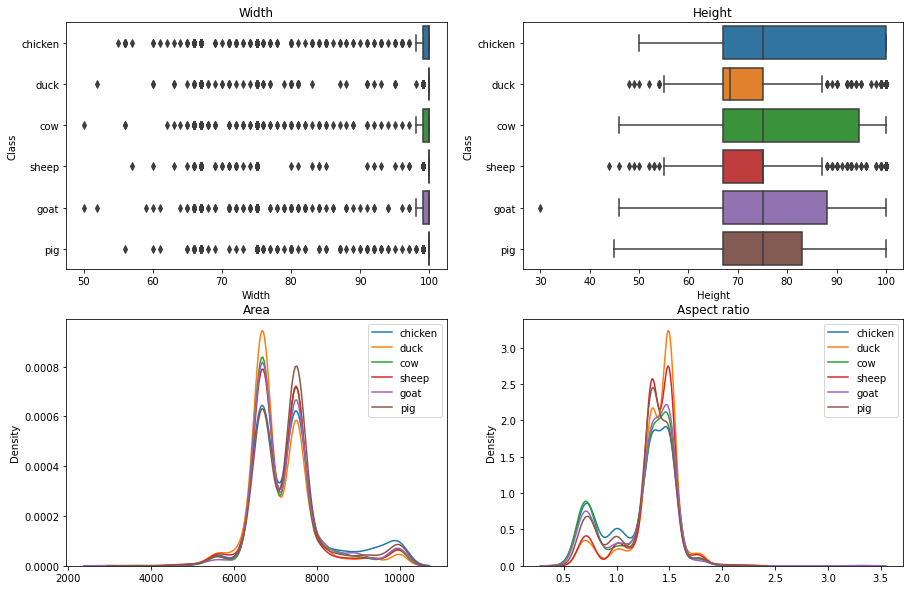

In [32]:
import seaborn as sns

def get_size(path):
    image = cv2.imread(path)
    shape = image.shape[:2]

    return shape[1], shape[0], shape[1]*shape[0], shape[1]/shape[0]
  
all_classes = ["chicken", "duck", "cow", "sheep", "goat", "pig"]

widths = []
heights = []
areas = []
ratios = []

fig, (row1, row2) = plt.subplots(2, 2, figsize=(15,10))
width = row1[0]
height = row1[1]
area = row2[0]
aspect = row2[1]

width_df = pd.DataFrame()
height_df = pd.DataFrame()

for i, c in enumerate(all_classes):
    paths = sorted(glob(f'livestock/train/{c}/*.*'))
    output = np.array([get_size(path) for path in paths])
      
    curr_width = output[:,0]
    curr_height = output[:,1]
    curr_area = output[:,2]
    curr_ratio = output[:,3]
    
    width_dict = {"Width": curr_width, "Class": [c for _ in range(len(curr_width))]}
    height_dict = {"Height": curr_height, "Class": [c for _ in range(len(curr_height))]}
    
    width_df = pd.concat([width_df, pd.DataFrame(width_dict)])
    height_df = pd.concat([height_df, pd.DataFrame(height_dict)])
    areas.append(curr_area)
    ratios.append(curr_ratio)

    sns.kdeplot(curr_area, label = c, ax=area)
    sns.kdeplot(curr_ratio, label = c, ax=aspect)

sns.boxplot(data=width_df, x="Width", y="Class", ax=width)
sns.boxplot(data=height_df, x="Height", y="Class", ax=height)
width.set_title('Width')
height.set_title('Height')
area.set_title('Area')
aspect.set_title('Aspect ratio')

area.legend()
aspect.legend()

plt.show()

The first thing that we can see here is that the data distribution for each class is roughly the same. This means that the data we gathered is more or less balanced. Additionally it is representative of each class. This means that we can proceed with using our dataset.

The second things we want to point our here is that the aspect ratios of the data are not that extreme. This would mean that resizing them to a 96x96 square is not such a bad idea. If for example we see that majority of our aspect ratio is 2 or 3 for example using a square may be a bad idea.

Some quick sanity check as well and we can see that majority of the data have a width of 100 and a height of around 68 to 80. This is consistent with the fact that majority of the data have an aspect ratio of 1.5.

## III. Cleaning the data

Here we will do our basic cleaning of the data. This involves two things, removing duplicates and removing noise/outliers.

### Removing Duplicates
The first thing that we need to do is to remove duplicates. We do this because duplicates don't really add any new information or value to our data. Additionally, we don't want a duplicates of our data in the train set to be in the test set since that will skew the results. For this step we can use off the shelf applications to detect image duplicates here and remove them.

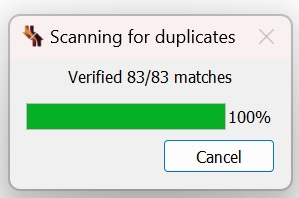

A sample duplicate: 
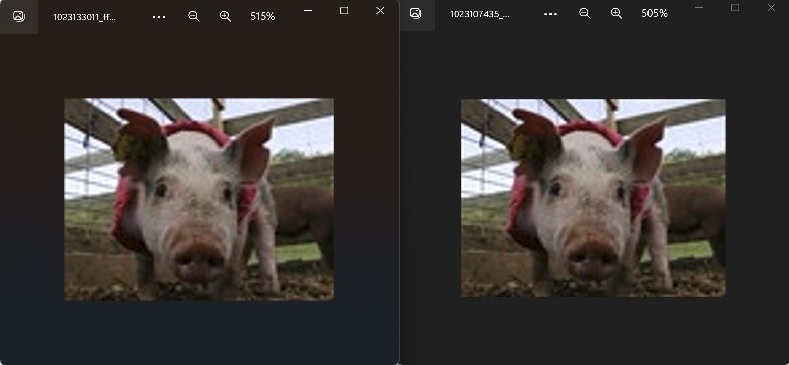

### Removing Noise

After retrieving our data, we need to make sure that it makes sense. To do this we need to go through the images and check that they actually fall into their label. We need to do this to make sure that our model learns what we actually want it to learn. This step is very time consuming as the data that we retrieve is full of noise. This is particularly true for categories such as pig as cooked pork, butcheries and pig treated as an adjective for people tend to pop up. For context, in around 2000 images retrieved, only about 300 or so would be actually relevant.

Sample Noise for Pig:
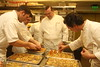

## IV. Segregating our data
Since our data has been cleaned, we can now split it and segregate it into training, validation and test set. While this can be done in later steps, doing it now will be convenient. The way we will be doing this is to create three folders for each of our datasets. We will then randomly select from our main folder 400 items which will be put in the test set and another 400 items which will be put in the validation set. The rest of the 1200 items will be used for our training.

In [ ]:
import os
import random
import shutil

test_size = 400
val_size = 400
categories = ["chicken", "duck", "goat", "pig", "cow", "sheep"]

for c in categories:
    source = c
    train_dest = f"train/{c}"
    test_dest = f"test/{c}"
    val_dest = f"validation/{c}"
    
    images = os.listdir(source)
    for i in random.sample(images, test_size):
        shutil.move(os.path.join(source, i), test_dest)
    
    images = os.listdir(source)
    for i in random.sample(images, val_size):
        shutil.move(os.path.join(source, i), val_dest)
        
    images = os.listdir(source)
    for i in images:
        shutil.move(os.path.join(source, i), train_dest)